<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/Image%20Datasets/deepFashion_Similar_Images_Annoy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on this [medium article](https://towardsdatascience.com/similar-images-recommendations-using-fastai-and-annoy-16d6ceb3b809).
The code is just the colab compatible Jupyter notebook created from this file from [jovian notebook](https://jvn.io/gautham20/deepfashion-similar-images-annoy).



In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 

In [0]:
from fastai.vision import *
import pandas as pd
import numpy as np

## Read Dataset Files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# get_category_names
with open('/content/drive/My Drive/MLAI_Datasets/DeepFashion/Category and Attribute Prediction Benchmark/Anno/list_category_cloth.txt', 'r') as f:
    categories = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            categories.append(line.split(' ')[0])

In [0]:
# get image category map
with open('/content/drive/My Drive/MLAI_Datasets/DeepFashion/Category and Attribute Prediction Benchmark/Anno/list_category_img.txt', 'r') as f:
    images = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            images.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [0]:
#get train, valid, test split
with open('/content/drive/My Drive/MLAI_Datasets/DeepFashion/Category and Attribute Prediction Benchmark/Eval/list_eval_partition.txt', 'r') as f:
    images_partition = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            images_partition.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [0]:
data_df = pd.DataFrame(images, columns=['images', 'category_label'])
partition_df = pd.DataFrame(images_partition, columns=['images', 'dataset'])

In [0]:
data_df['category_label'] = data_df['category_label'].astype(int)

In [0]:
data_df = data_df.merge(partition_df, on='images')

In [10]:
data_df['dataset'].value_counts()

train    209222
test      40000
val       40000
Name: dataset, dtype: int64

In [0]:
data_df['category'] = data_df['category_label'].apply(lambda x: categories[int(x) - 1])

In [12]:
data_df['category_label'].nunique()
# seems like few labels were merged in Dress label

46

In [13]:
data_df.head()

,images,category_label,dataset,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3,train,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3,train,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3,val,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3,train,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3,test,Blouse


## prepare DataBunch

In [0]:
!unzip '/content/drive/My Drive/MLAI_Datasets/DeepFashion/Category and Attribute Prediction Benchmark/Img/img.zip'

In [0]:
#!unzip '/content/drive/My Drive/MLAI_Datasets/DeepFashion/Category and Attribute Prediction Benchmark/Img/img_highres.zip'

In [0]:
from pathlib import Path
images_path = Path('/content/')

In [0]:
data_source = (ImageList.from_df(df=data_df, path=images_path, cols='images')
                    .split_by_idxs((data_df[data_df['dataset']=='train'].index), (data_df[data_df['dataset']=='val'].index))
                    .label_from_df(cols='category')
              )

In [0]:
tmfs = get_transforms()

data = data_source.transform(tmfs, size=224).databunch(bs=128).normalize(imagenet_stats)

In [0]:
test_data = ImageList.from_df(df=data_df[data_df['dataset'] == 'test'], path=images_path, cols='images')
data.add_test(test_data)

In [0]:
# To maintain the order of images in train data, turning off shuffle
# data.train_dl = data.train_dl = data.train_dl.new(shuffle=False)

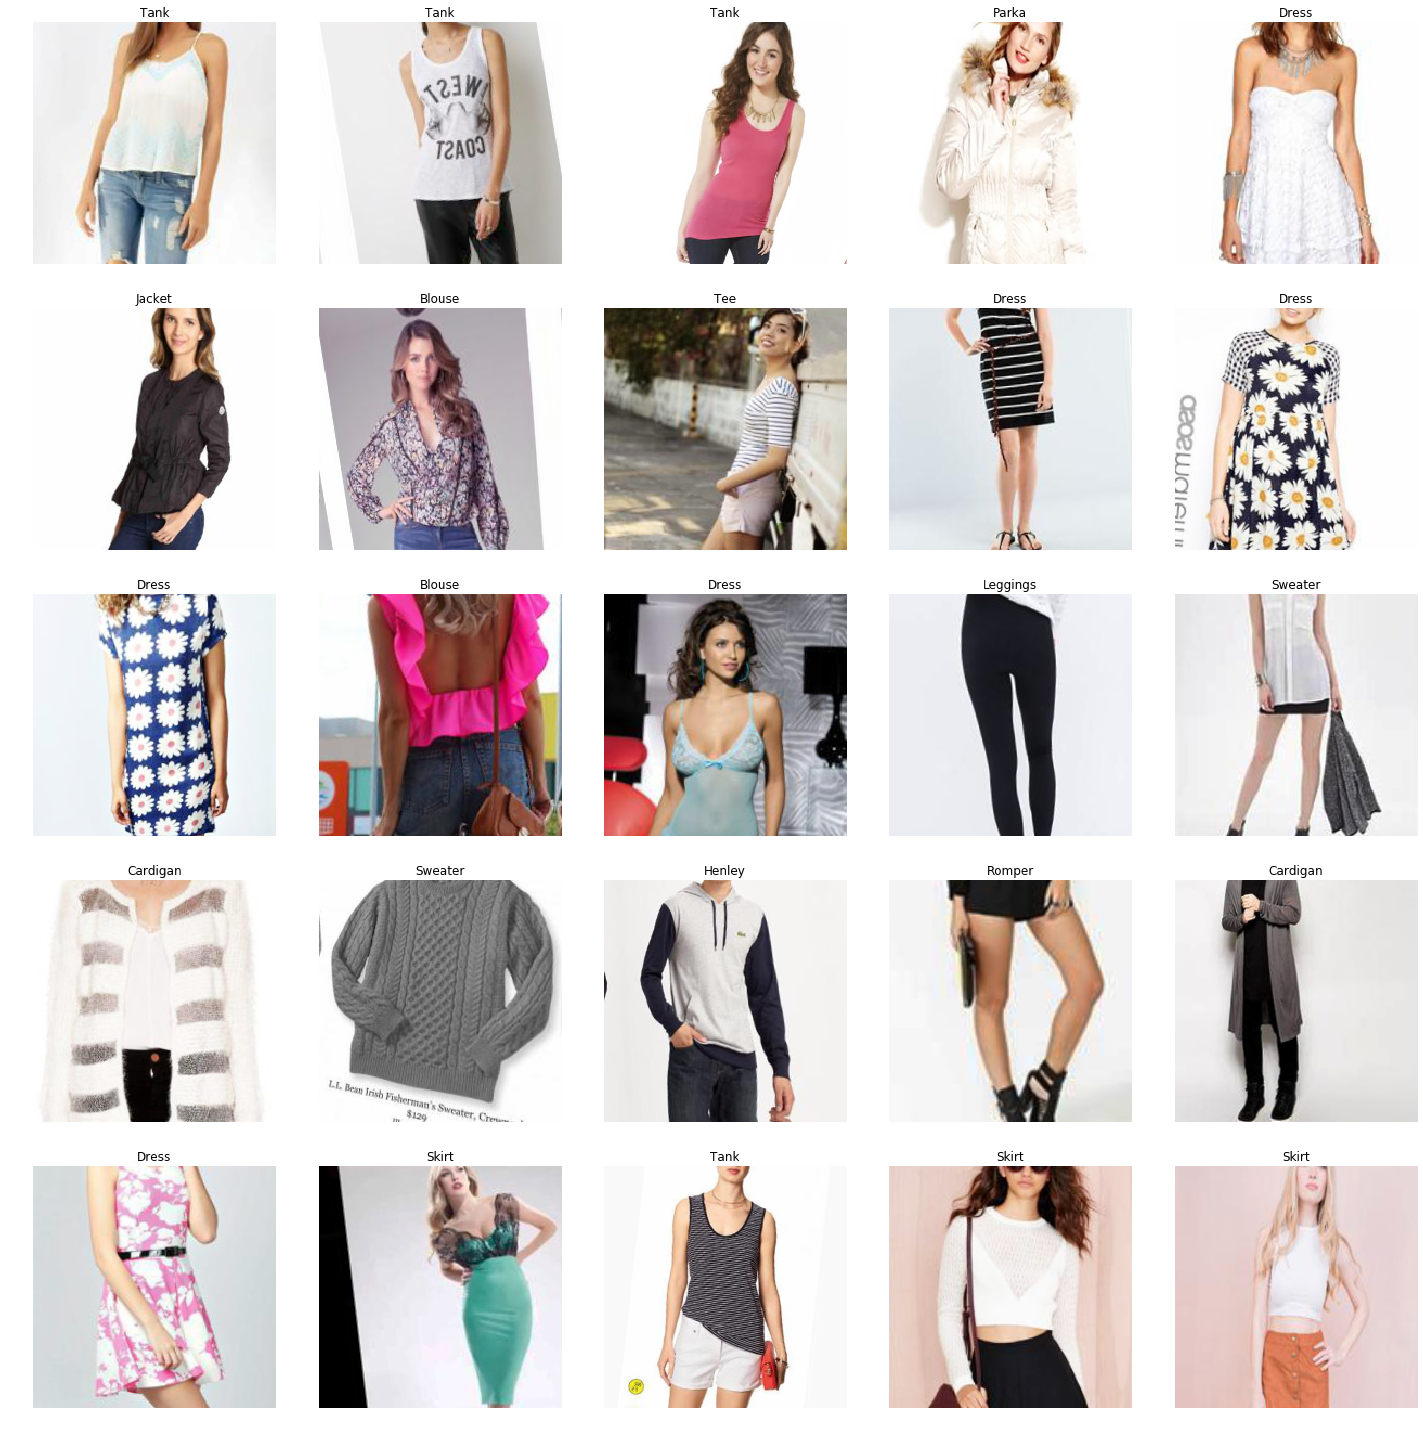

In [21]:
data.show_batch()

In [22]:
data

ImageDataBunch;

Train: LabelList (209222 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Blouse,Blouse,Blouse,Blouse,Blouse
Path: /content;

Valid: LabelList (40000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Blouse,Blouse,Blouse,Blouse,Blouse
Path: /content;

Test: LabelList (40000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content

## ResNet50 pretrained model

In [0]:
from fastai.metrics import accuracy, top_k_accuracy

top_3_accuracy = partial(top_k_accuracy, k=3)
top_5_accuracy = partial(top_k_accuracy, k=5)

In [24]:
learner = cnn_learner(data, models.resnet34, metrics=[accuracy, top_3_accuracy, top_5_accuracy])
learner.model = torch.nn.DataParallel(learner.model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 105836199.69it/s]


In [0]:
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(2, max_lr=1e-03)

In [0]:
#!cp /content/resnet34-224-freezed.pth /content/models/resnet34-224-freezed.pth
#!cp /content/tmp.pth /content/models/tmp.pth

In [30]:
learner.save('resnet34-224-freezed')
#learner.load('resnet34-224-freezed') #path is /content/models/resnet34-224-freezed.pth and /content/models/tmp.pth

Learner(data=ImageDataBunch;

Train: LabelList (209222 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Blouse,Blouse,Blouse,Blouse,Blouse
Path: /content;

Valid: LabelList (40000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Blouse,Blouse,Blouse,Blouse,Blouse
Path: /content;

Test: LabelList (40000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4

In [0]:
# .module because DataParallel was used
model = learner.model.module

## Get image feature vectors

In [0]:
class Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
        "Applies `hook_func` to `module`, `input`, `output`."
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
        
def get_output(module, input_value, output):
    return output.flatten(1)

def get_input(module, input_value, output):
    return list(input_value)[0]

def get_named_module_from_model(model, name):
    for n, m in model.named_modules():
        if n == name:
            return m
    return None

In [34]:
linear_output_layer = get_named_module_from_model(model, '1.4')
linear_output_layer

Linear(in_features=1024, out_features=512, bias=True)

In [0]:
# getting all images in train
train_valid_images_df = data_df[data_df['dataset'] != 'test']
inference_data_source = (ImageList.from_df(df=train_valid_images_df, path=images_path, cols='images')
                    .split_none()
                    .label_from_df(cols='category')
              )

In [0]:
inference_data = inference_data_source.transform(tmfs, size=224).databunch(bs=32).normalize(imagenet_stats)

In [0]:
inference_dataloader = inference_data.train_dl.new(shuffle=False)

In [38]:
import time
img_repr_map = {}

with Hook(linear_output_layer, get_output, True, True) as hook:
    start = time.time()
    for i, (xb, yb) in enumerate(inference_dataloader):
        bs = xb.shape[0]
        img_ids = inference_dataloader.items[i*bs: (i+1)*bs]
        result = model.eval()(xb)
        img_reprs = hook.stored.cpu().numpy()
        img_reprs = img_reprs.reshape(bs, -1)
        for img_id, img_repr in zip(img_ids, img_reprs):
            img_repr_map[img_id] = img_repr
        if(len(img_repr_map) % 12800 == 0):
            end = time.time()
            print(f'{end-start} secs for 12800 images')
            start = end

130.7058448791504 secs for 12800 images
129.30414652824402 secs for 12800 images
129.13494300842285 secs for 12800 images
128.24606037139893 secs for 12800 images
129.82951045036316 secs for 12800 images
134.10658049583435 secs for 12800 images
129.62286520004272 secs for 12800 images
128.52907061576843 secs for 12800 images
128.8004641532898 secs for 12800 images
129.73490381240845 secs for 12800 images
131.51707673072815 secs for 12800 images
129.60876059532166 secs for 12800 images
129.54260349273682 secs for 12800 images
130.25561046600342 secs for 12800 images
132.06082844734192 secs for 12800 images
131.82740926742554 secs for 12800 images
131.4712052345276 secs for 12800 images
131.15956115722656 secs for 12800 images
132.60492849349976 secs for 12800 images


In [0]:
img_repr_df = pd.DataFrame(img_repr_map.items(), columns=['img_id', 'img_repr'])

In [40]:
img_repr_df.shape

(249216, 2)

In [0]:
img_repr_df['label'] = [inference_data.classes[x] for x in inference_data.train_ds.y.items[0:img_repr_df.shape[0]]]

In [0]:
img_repr_df['label_id'] = inference_data.train_ds.y.items[0:img_repr_df.shape[0]]

## Getting similar images with cosine distance

In [0]:
from scipy.spatial.distance import cosine

def get_similar_images(img_index, n=10):
    start = time.time()
    base_img_id, base_vector, base_label  = img_repr_df.iloc[img_index, [0, 1, 2]]
    cosine_similarity = 1 - img_repr_df['img_repr'].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    end = time.time()
    print(f'{end - start} secs')
    return base_img_id, base_label, img_repr_df.iloc[similar_img_ids]

def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_id']]
    categories = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys(images, categories)

In [44]:
base_image, base_label, similar_images_df = get_similar_images(30000)

13.375070333480835 secs


Hoodie
/content/img/Sleeveless_Zip-Front_Hoodie/img_00000002.jpg


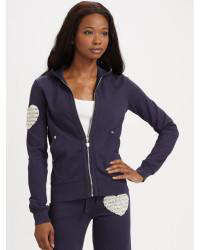

In [45]:
print(base_label)
print(base_image)
open_image(base_image)

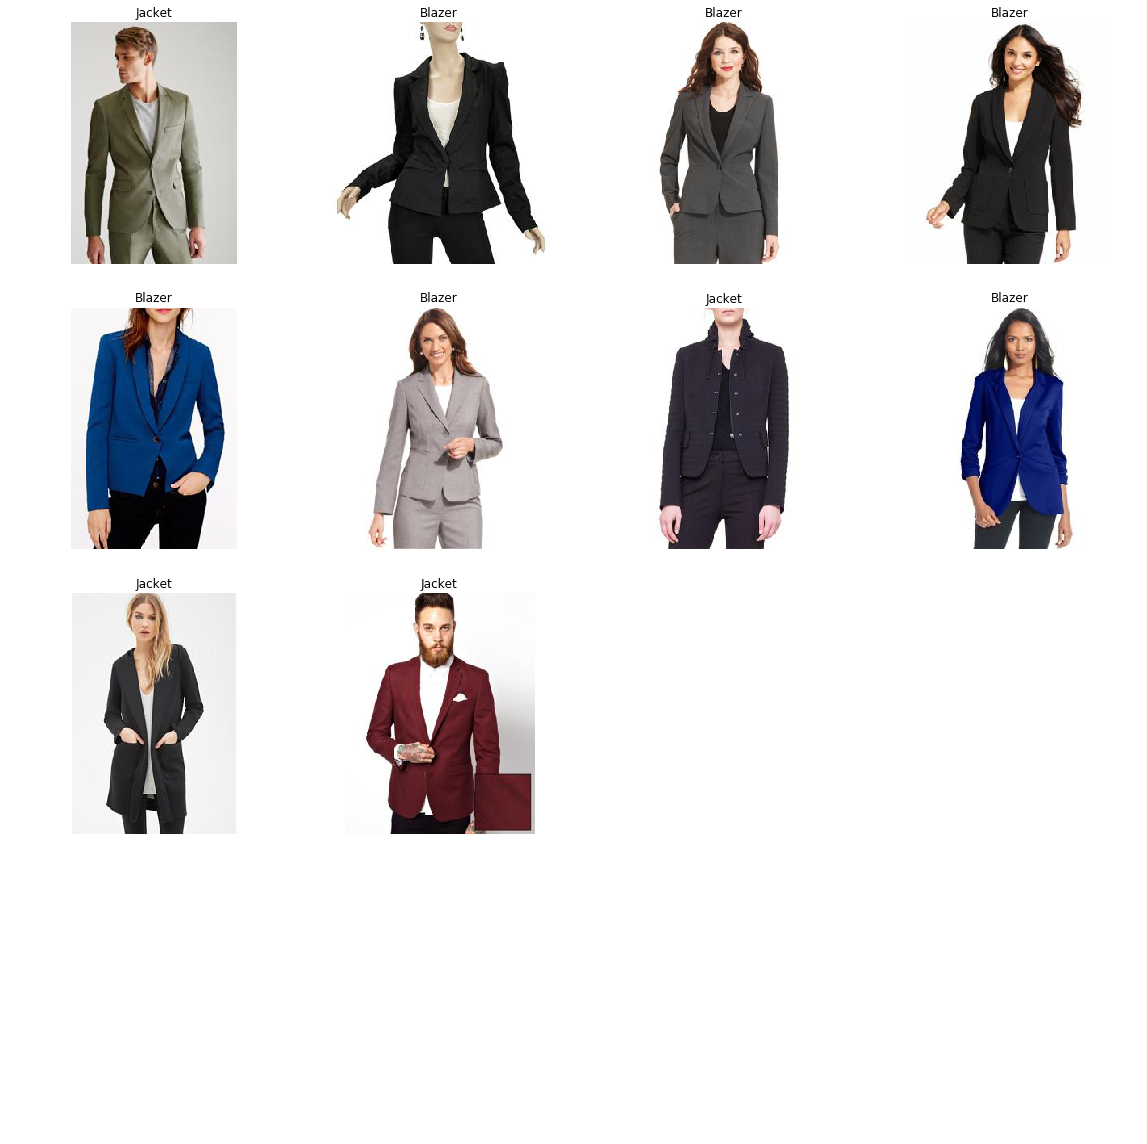

In [46]:
show_similar_images(similar_images_df)

## Using Annoy - Approximate Nearest Neighbors Oh Yeah!

In [0]:
!pip install annoy

In [0]:
from annoy import AnnoyIndex

In [0]:
f = len(img_repr_df['img_repr'][0])
t = AnnoyIndex(f, metric='euclidean')

In [0]:
for i, vector in enumerate(img_repr_df['img_repr']):
    t.add_item(i, vector)
_  = t.build(inference_data.c)

In [0]:
def get_similar_images_annoy(img_index):
    start = time.time()
    base_img_id, base_vector, base_label  = img_repr_df.iloc[img_index, [0, 1, 2]]
    similar_img_ids = t.get_nns_by_item(img_index, 13)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    return base_img_id, base_label, img_repr_df.iloc[similar_img_ids[1:]]

In [52]:
# 230000, 130000, 190000
base_image, base_label, similar_images_df = get_similar_images_annoy(149999)

2.774477005004883 ms


Shorts


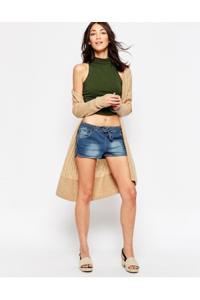

In [53]:
print(base_label)
open_image(base_image)

In [54]:
similar_images_df

,img_id,img_repr,label,label_id
122269,/content/img/Mesh_Zippered_Mini_Skirt/img_0000...,"[1.2976154, 0.0, 0.0, 0.82824224, 0.0, 1.09520...",Skirt,37
158675,/content/img/Striped_Southwestern-Patterned_Sh...,"[3.4737022, 0.0, 0.0, 1.4085534, 0.0, 0.0, 0.0...",Shorts,36
139611,/content/img/Western-Inspired_Denim_Shorts/img...,"[3.0519679, 0.0, 0.0, 0.0, 0.0, 0.9171436, 0.0...",Shorts,36
156994,/content/img/Palm_Tree_Print_Shorts/img_000000...,"[0.8819018, 0.0, 0.0, 1.0189896, 0.0, 0.0, 0.0...",Shorts,36
163878,/content/img/Embroidered_Panel_Cutoffs/img_000...,"[3.5050054, 0.0, 0.0, 0.49701396, 0.0, 0.0, 0....",Cutoffs,12
122578,/content/img/Medium_Wash_Distressed_Denim_Shor...,"[2.4561074, 0.0, 0.0, 0.43487674, 0.0, 0.82942...",Shorts,36
151319,/content/img/Sequined_Mini_Skirt/img_00000084.jpg,"[3.447473, 0.0, 0.0, 1.7906654, 0.0, 0.3068822...",Skirt,37
164369,/content/img/Faded_&_Frayed_Denim_Cutoffs/img_...,"[2.6569583, 0.0, 0.0, 2.4690697, 0.0, 0.0, 0.0...",Cutoffs,12
142923,/content/img/High-Waisted_Plaid_Shorts/img_000...,"[2.4879436, 0.0, 0.0, 1.2869401, 0.0, 0.0, 0.0...",Shorts,36
137390,/content/img/Floral_Lace_Elasticized_Shorts/im...,"[2.2150536, 0.0, 0.0, 2.0897598, 0.0, 0.0, 0.0...",Shorts,36


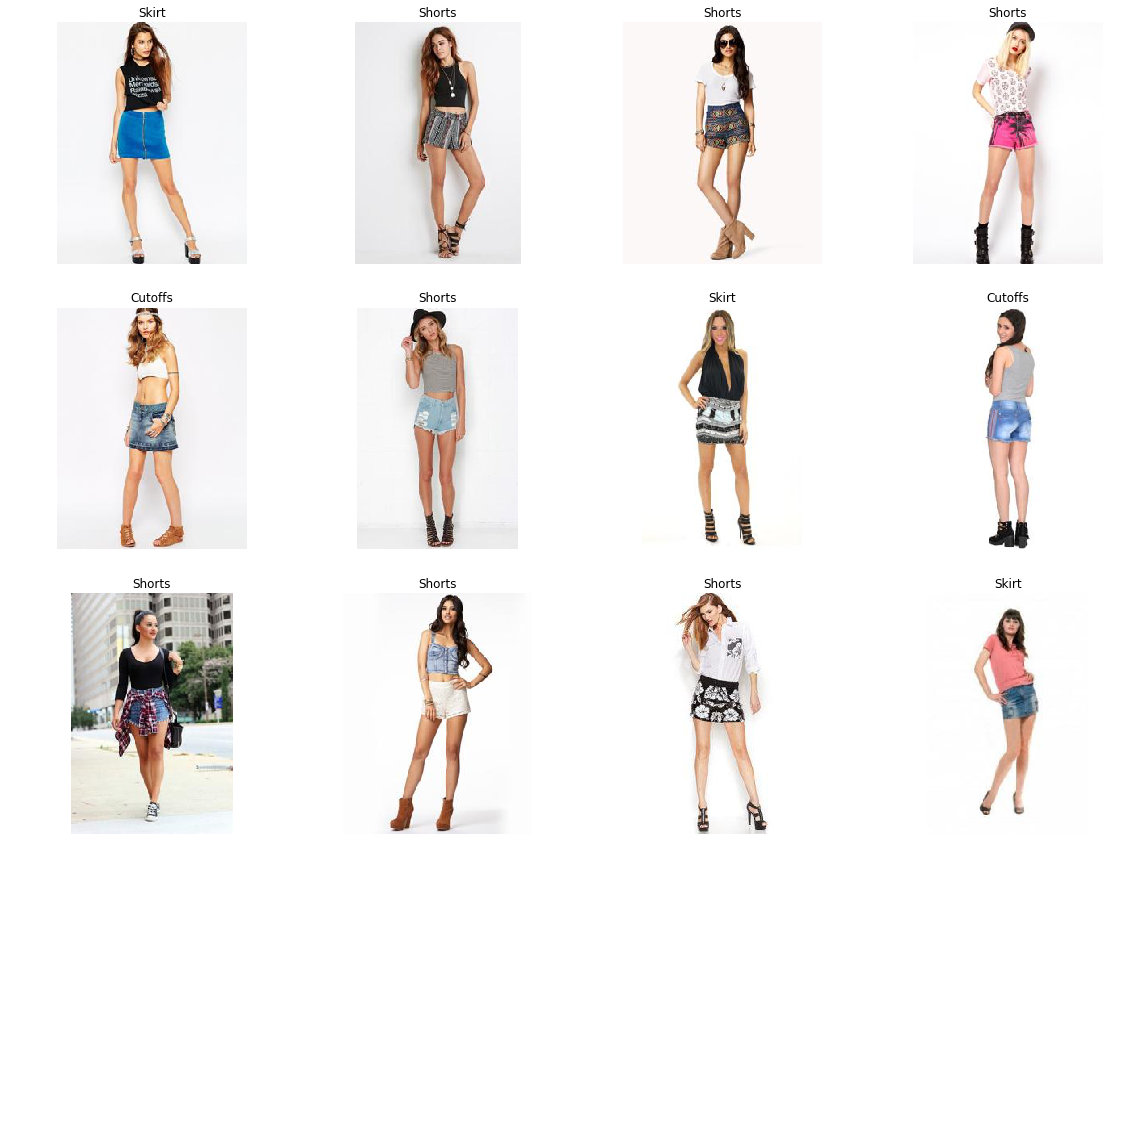

In [55]:
show_similar_images(similar_images_df)

## TSNE plot

In [0]:
from sklearn.manifold import TSNE

img_repr_matrix = [list(x) for x in img_repr_df['img_repr'].values]
tsne = TSNE(n_components=3, verbose=10, init='pca', perplexity=30, n_iter=500, n_iter_without_progress=100)
tsne_results_3 = tsne.fit_transform(img_repr_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 249216 samples in 261.620s...


In [0]:
img_repr_df['tsne1'] = tsne_results_3[:,0]
img_repr_df['tsne2'] = tsne_results_3[:,1]
img_repr_df['tsne3'] = tsne_results_3[:,2]

In [0]:
img_repr_df.to_parquet('deepFashion_similar_images')

In [0]:
import plotly_express as px
px.scatter_3d(img_repr_df, x='tsne1', y='tsne2', z='tsne3', color='label')